In [29]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings 
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *
from statsforecast import StatsForecast
from statsforecast.models import (
    Naive,
    WindowAverage,
    AutoARIMA,
    SeasonalNaive,
    HoltWinters,
    CrostonClassic as Croston, 
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive
)

warnings.filterwarnings("ignore")  # To ignore warnings from pandas/numpy

In [30]:
user="lholguin"

### Statistical Models - Dataset with pop

In [31]:
def load_and_prepare_data(filepath, states=None):

    df = pd.read_csv(filepath)
    
    if states is not None:
        if isinstance(states, str):
            states = [states]
        print(f"Filtering data for states: {states}")
        df=df[df['State'].isin(states)].copy()
        print(f"Filtered to {len(df)} rows across {df['State'].nunique()} state(s).")

        if len(df) == 0:
            raise ValueError("No data available for the specified states.")
    
    df['unique_id'] = df['State'] + '_' + df['ATC2 Class']
    df['ds'] = pd.to_datetime(df['Period'])
    df = df.sort_values(['unique_id','ds']).reset_index(drop=True)

    #Preparing dataframes for statsforecast
    df_units=df[['unique_id','ds','Units Reimbursed']].copy()
    df_units.columns=['unique_id','ds','y']

    df_prescriptions=df[['unique_id','ds','Number of Prescriptions']].copy()
    df_prescriptions.columns=['unique_id','ds','y']

    return df_units, df_prescriptions, df

In [32]:
def get_models():

    models = [
        Naive(), HistoricAverage(), WindowAverage(window_size=4),
        SeasonalNaive(season_length=4), AutoARIMA(seasonal=False,alias="ARIMA"),
        AutoARIMA(seasonal=True,season_length=4,alias="SARIMA"),
        HoltWinters(season_length=4), DOT(season_length=4),
    ]
    return models

def train_and_forecast(df,target_name, h=4):
    
    sf=StatsForecast(models=get_models(),freq='QS', n_jobs=-1,fallback_model=SeasonalNaive(season_length=4))
    
    forecasts_df=sf.forecast(df=df, h=h, level=[95])
    print(f"Forecast results for {target_name}:"); print(forecasts_df.head())
    return forecasts_df, sf
    
def evaluate_models(df,target_name,n_windows=5, h=4):
    
    sf=StatsForecast(models=get_models(),freq='QS', n_jobs=-1,fallback_model=SeasonalNaive(season_length=4))

    print(f"Running cross-validation for {target_name} with {n_windows} windows and horizon {h}...")
    cv_df=sf.cross_validation(df=df, h=h, n_windows=n_windows, step_size=h)
    
    # Errors metrics calculation
    models=[col for col in cv_df.columns if col not in ['unique_id','ds','y','cutoff']]
    
    mse_scores=mse(cv_df, models=models); mse_scores['metric']='MSE'
    mae_scores=mae(cv_df, models=models); mae_scores['metric']='MAE'
    rsme_scores=rmse(cv_df, models=models); rsme_scores['metric']='RMSE'
    evaluation_df=pd.concat([mse_scores, mae_scores, rsme_scores])

    #Let's determine the best model based on MSE
    best_models=mse_scores[models].idxmin(axis=1)
    evaluation_df_sumary=mse_scores.copy()
    evaluation_df_sumary['best_model']=best_models

    print(f"\nBest Models Summary for {target_name}:")
    print(evaluation_df_sumary['best_model'].value_counts())
    return cv_df,evaluation_df, evaluation_df_sumary

def get_best_model_forecast(forecasts_df,evaluation_df_sumary):

    best_info=evaluation_df_sumary[['unique_id','best_model']]
    forecasts_with_best=forecasts_df.reset_index().merge(best_info, on='unique_id', how='left')
    result=forecasts_with_best[['unique_id','ds']].copy()
    
    result['best_forecast']=forecasts_with_best.apply(
        lambda row: row[row['best_model']], axis=1)

    #confidence intervals
    for level in [95]:
        lo_col = f'best_forecast-lo-{level}'
        hi_col = f'best_forecast-hi-{level}'
        
        result[lo_col] = forecasts_with_best.apply(
            lambda row: row.get(f"{row['best_model']}-lo-{level}", np.nan), axis=1
        )
        result[hi_col] = forecasts_with_best.apply(
            lambda row: row.get(f"{row['best_model']}-hi-{level}", np.nan), axis=1
        )
    result=result.merge(best_info, on='unique_id')
    return result

def save_results(forecasts_df,best_forecasts_df,evaluation_df,target_name):
    
    prefix=target_name.lower().replace(' ','_')
    forecasts_df.reset_index().to_csv(f"{prefix}_all_model_forecasts.csv", index=False)
    best_forecasts_df.to_csv(f"{prefix}_best_model_forecasts.csv", index=False)
    evaluation_df.to_csv(f"{prefix}_model_evaluation.csv", index=False)
    
    print(f"✓ Results saved: {prefix}_*.csv")
    #Save those
    
def plot_sample_forecasts(df,forecasts_df,target_name,n_samples=4):

    unique_ids = df['unique_id'].unique()
    sample_ids = np.random.choice(unique_ids, min(n_samples, len(unique_ids)), replace=False)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, uid in enumerate(sample_ids):
        ax = axes[idx]
        
        # Historical data
        hist_data = df[df['unique_id'] == uid]
        ax.plot(hist_data['ds'], hist_data['y'], 'o-', label='Historical', linewidth=2)
        
        # Forecast data (just plot one model for clarity - SeasonalNaive)
        forecast_data = forecasts_df.reset_index()
        forecast_data = forecast_data[forecast_data['unique_id'] == uid]
        
        if 'SeasonalNaive' in forecast_data.columns:
            ax.plot(forecast_data['ds'], forecast_data['SeasonalNaive'], 
                   's-', label='SeasonalNaive', linewidth=2)
        
        if 'AutoARIMA' in forecast_data.columns:
            ax.plot(forecast_data['ds'], forecast_data['AutoARIMA'], 
                   '^-', label='AutoARIMA', linewidth=2)
        
        ax.set_title(f'{uid}', fontsize=10, fontweight='bold')
        ax.set_xlabel('Date')
        ax.set_ylabel(target_name)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{target_name.lower().replace(" ", "_")}_sample_forecasts.png', dpi=150, bbox_inches='tight')
    print(f"✓ Plot saved: {target_name.lower().replace(' ', '_')}_sample_forecasts.png")
    plt.show()

In [33]:
def main(filepath, states=None, h=4, run_cv=True, n_windows=5):
    
    print("\n" + "="*70)
    print("STATSFORECAST PHARMACEUTICAL FORECASTING PIPELINE")
    print("="*70)
    
    # ========================================================================
    # 1. LOAD AND PREPARE DATA
    # ========================================================================
    print("\n[1/5] Loading and preparing data...")
    df_units, df_prescriptions, df_original = load_and_prepare_data(filepath, states=states)
    
    # Display summary
    print(f"\n📊 Data Summary:")
    print(f"  • Total unique series: {df_units['unique_id'].nunique()}")
    min_date = df_units['ds'].min()
    max_date = df_units['ds'].max()
    print(f"  • Date range: {min_date.year}-Q{min_date.quarter} to {max_date.year}-Q{max_date.quarter}")
    if states is not None:
        print(f"  • Filtered states: {', '.join(states)}")
    
    # ========================================================================
    # 2. UNITS REIMBURSED - FORECASTING
    # ========================================================================
    print("\n" + "="*70)
    print("UNITS REIMBURSED")
    print("="*70)
    
    print("\n[2/5] Training models and generating forecasts...")
    forecasts_units, sf_units = train_and_forecast(df_units, "Units Reimbursed", h=h)
    
    if run_cv:
        print("\n[3/5] Running cross-validation...")
        cv_units, eval_units, eval_summary_units = evaluate_models(
            df_units, "Units Reimbursed", n_windows=n_windows, h=h
        )
        
        print("\n[4/5] Selecting best forecasts...")
        best_forecasts_units = get_best_model_forecast(forecasts_units, eval_summary_units)
        
        print("\n[5/5] Saving results...")
        save_results(forecasts_units, best_forecasts_units, eval_units, "Units Reimbursed")
    else:
        eval_units = None
        best_forecasts_units = forecasts_units.reset_index()
        print("\n[3-5/5] Skipping cross-validation (run_cv=False)")
    
    # Plot sample forecasts
    print("\n📈 Generating forecast plots...")
    plot_sample_forecasts(df_units, forecasts_units, "Units Reimbursed", n_samples=4)
    
    # ========================================================================
    # 3. NUMBER OF PRESCRIPTIONS - FORECASTING
    # ========================================================================
    print("\n" + "="*70)
    print("NUMBER OF PRESCRIPTIONS")
    print("="*70)
    
    print("\n[2/5] Training models and generating forecasts...")
    forecasts_prescriptions, sf_prescriptions = train_and_forecast(
        df_prescriptions, "Number of Prescriptions", h=h
    )
    
    if run_cv:
        print("\n[3/5] Running cross-validation...")
        cv_prescriptions, eval_prescriptions, eval_summary_prescriptions = evaluate_models(
            df_prescriptions, "Number of Prescriptions", n_windows=n_windows, h=h
        )
        
        print("\n[4/5] Selecting best forecasts...")
        best_forecasts_prescriptions = get_best_model_forecast(
            forecasts_prescriptions, eval_summary_prescriptions
        )
        
        print("\n[5/5] Saving results...")
        save_results(
            forecasts_prescriptions, 
            best_forecasts_prescriptions, 
            eval_prescriptions, 
            "Number of Prescriptions"
        )
    else:
        eval_prescriptions = None
        best_forecasts_prescriptions = forecasts_prescriptions.reset_index()
        print("\n[3-5/5] Skipping cross-validation (run_cv=False)")
    
    # Plot sample forecasts
    print("\n📈 Generating forecast plots...")
    plot_sample_forecasts(
        df_prescriptions, 
        forecasts_prescriptions, 
        "Number of Prescriptions", 
        n_samples=4
    )
    
    # ========================================================================
    # 4. FINAL SUMMARY
    # ========================================================================
    print("\n" + "="*70)
    print("✅ PIPELINE COMPLETE!")
    print("="*70)
    
    state_info = f"{', '.join(states)}" if states else "ALL"
    print(f"\n🎯 Forecasts generated for state(s): {state_info}")
    print(f"📅 Forecast horizon: {h} quarters ahead")
    
    if run_cv:
        print(f"\n📁 Generated Files:")
        print(f"   • units_reimbursed_all_model_forecasts.csv")
        print(f"   • units_reimbursed_best_model_forecasts.csv")
        print(f"   • units_reimbursed_model_evaluation.csv")
        print(f"   • number_of_prescriptions_all_model_forecasts.csv")
        print(f"   • number_of_prescriptions_best_model_forecasts.csv")
        print(f"   • number_of_prescriptions_model_evaluation.csv")
    
    print(f"\n📊 Generated Plots:")
    print(f"   • units_reimbursed_sample_forecasts.png")
    print(f"   • number_of_prescriptions_sample_forecasts.png")
    
    print("\n" + "="*70)
    
    # Optional: Return results for programmatic access
    return {
        'units': {
            'forecasts': forecasts_units,
            'best_forecasts': best_forecasts_units if run_cv else None,
            'evaluation': eval_units if run_cv else None,
        },
        'prescriptions': {
            'forecasts': forecasts_prescriptions,
            'best_forecasts': best_forecasts_prescriptions if run_cv else None,
            'evaluation': eval_prescriptions if run_cv else None,
        }
    }


STATSFORECAST PHARMACEUTICAL FORECASTING PIPELINE

[1/5] Loading and preparing data...
Filtering data for states: ['IN']
Filtered to 2971 rows across 1 state(s).

📊 Data Summary:
  • Total unique series: 83
  • Date range: 2016-Q1 to 2024-Q4
  • Filtered states: IN

UNITS REIMBURSED

[2/5] Training models and generating forecasts...
Forecast results for Units Reimbursed:
  unique_id         ds        Naive   Naive-lo-95   Naive-hi-95  \
0    IN_A01 2025-01-01   726622.955 -1.807447e+06  3.260693e+06   
1    IN_A01 2025-04-01   726622.955 -2.857093e+06  4.310339e+06   
2    IN_A01 2025-07-01   726622.955 -3.662515e+06  5.115760e+06   
3    IN_A01 2025-10-01   726622.955 -4.341516e+06  5.794762e+06   
4    IN_A02 2025-01-01  6789285.875  5.060947e+06  8.517624e+06   

   HistoricAverage  HistoricAverage-lo-95  HistoricAverage-hi-95  \
0     1.763991e+06          -2.532250e+05           3.781206e+06   
1     1.763991e+06          -2.532250e+05           3.781206e+06   
2     1.763991e+06

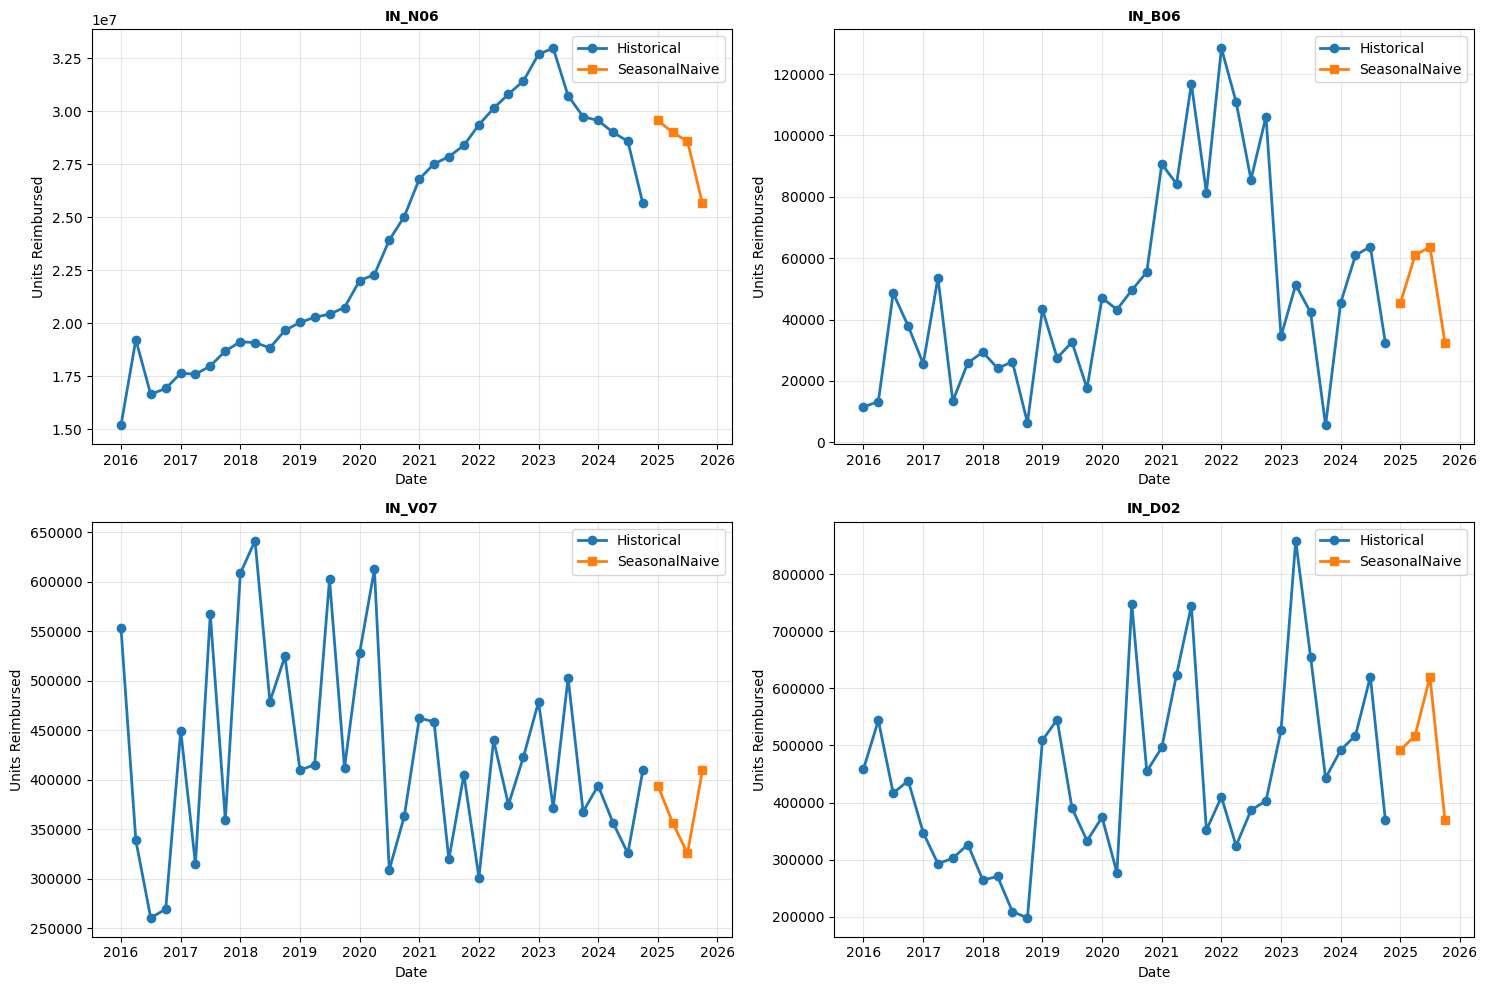


NUMBER OF PRESCRIPTIONS

[2/5] Training models and generating forecasts...
Forecast results for Number of Prescriptions:
  unique_id         ds     Naive   Naive-lo-95    Naive-hi-95  \
0    IN_A01 2025-01-01   26000.0  -3403.655273   55403.656250   
1    IN_A01 2025-04-01   26000.0 -15583.047852   67583.046875   
2    IN_A01 2025-07-01   26000.0 -24928.625000   76928.625000   
3    IN_A01 2025-10-01   26000.0 -32807.312500   84807.312500   
4    IN_A02 2025-01-01  120734.0  88292.671875  153175.328125   

   HistoricAverage  HistoricAverage-lo-95  HistoricAverage-hi-95  \
0     40597.417969           -5792.789551           86987.625000   
1     40597.417969           -5792.789551           86987.625000   
2     40597.417969           -5792.789551           86987.625000   
3     40597.417969           -5792.789551           86987.625000   
4    125657.718750           69858.734375          181456.703125   

   WindowAverage  WindowAverage-lo-95  ...    ARIMA-hi-95    SARIMA  \
0      

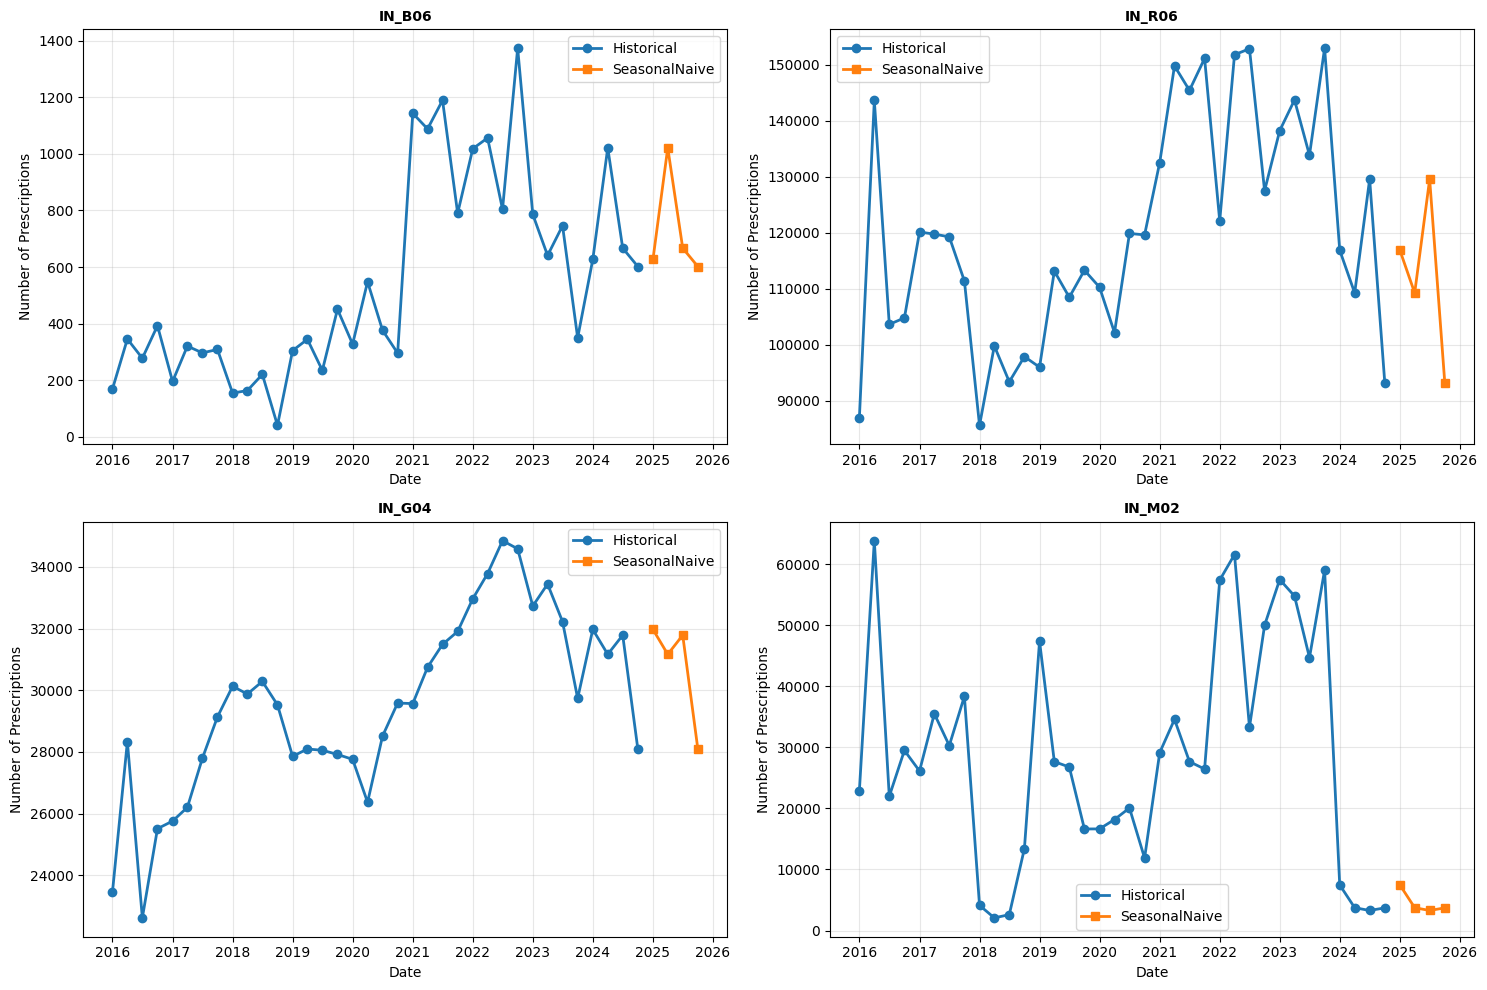


✅ PIPELINE COMPLETE!

🎯 Forecasts generated for state(s): IN
📅 Forecast horizon: 4 quarters ahead

📁 Generated Files:
   • units_reimbursed_all_model_forecasts.csv
   • units_reimbursed_best_model_forecasts.csv
   • units_reimbursed_model_evaluation.csv
   • number_of_prescriptions_all_model_forecasts.csv
   • number_of_prescriptions_best_model_forecasts.csv
   • number_of_prescriptions_model_evaluation.csv

📊 Generated Plots:
   • units_reimbursed_sample_forecasts.png
   • number_of_prescriptions_sample_forecasts.png



In [34]:
#path to the pre-built dataset
csv_path=rf"C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\merged_data\Prebuilt_panels\P1_nopop.csv"
if __name__ == "__main__":
    main(filepath=csv_path, states=['IN'], h=4, run_cv=True, n_windows=5)
  